<a href="https://colab.research.google.com/github/Song-Jun-Ho/RNN_Attention_Transformer/blob/main/hw4_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd '/content/drive/MyDrive/HW4'

/content/drive/MyDrive/HW4


In [ ]:
import math
import random
from pathlib import Path
import sys
sys.path.insert(0,str(Path().absolute().joinpath("data")))

from data import prepareData

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import Dataset, DataLoader, random_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BATCH_SIZE = 64

# TRAIN_RATIO: train dataset ratio, should be a float in (0, 0.8]
# (0.8-TRAIN_RATIO) will be used for valid dataset
TRAIN_RATIO = 0.6 

## Util

**Do NOT Modify** code blocks in this section

In [ ]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
def train(model, iterator, optimizer, loss_fn, clip):
    
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):

        src = batch[0].to(device)
        trg = batch[1].to(device)
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        loss = loss_fn(output, trg)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, loss_fn):
    
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch[0].to(device)
            trg = batch[1].to(device)

            output = model(src, trg)

            loss = loss_fn(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

## Dataset & Dataloader

**Do NOT Modify** code blocks in this section

In [ ]:
MAX_LENGTH = 10
VALID_RATIO = 0.8-TRAIN_RATIO

SOS_token = 0
EOS_token = 1

In [ ]:
class TranslateDataset(Dataset):
    def __init__(self, max_length=10, fra2eng=True):
        self.input_lang, self.output_lang, self.pairs = prepareData('eng', 'fra', max_length=max_length, reverse=fra2eng)
        self.max_length=max_length

        self.input_lang.addWord('PAD')
        self.output_lang.addWord('PAD')
        self.input_lang_pad = self.input_lang.word2index['PAD']
        self.output_lang_pad = self.output_lang.word2index['PAD']
        
        print("data example")
        print(random.choice(self.pairs))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        x, y = self._tensorsFromPair(pair)
        return x, y

    def _tensorFromSentence(self, lang, sentence):
        indexes = [lang.word2index[word] for word in sentence.split(' ')]
        indexes.append(EOS_token)
        return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

    def _tensorsFromPair(self, pair):
        input_tensor = self._tensorFromSentence(self.input_lang, pair[0])
        target_tensor = self._tensorFromSentence(self.output_lang, pair[1])
        return (input_tensor, target_tensor)
    
    def collate_fn(self, data):
        x_batch = []; y_batch = []
        
        for x, y in data:
            if x.shape[0] < self.max_length-1:
                x = torch.cat([x, self.input_lang_pad*torch.ones((self.max_length-1 - x.shape[0], 1), dtype=x.dtype)])
            elif x.shape[0] > self.max_length-1:
                x = x[:self.max_length-1]
            if y.shape[0] < self.max_length-1:
                y = torch.cat([y, self.output_lang_pad*torch.ones((self.max_length-1 - y.shape[0], 1), dtype=y.dtype)])
            elif y.shape[0] > self.max_length-1:
                y = y[:self.max_length-1]

            x_batch.append(torch.cat([torch.tensor([SOS_token]), x.squeeze(1)]))
            y_batch.append(torch.cat([torch.tensor([SOS_token]), y.squeeze(1)]))
        
        return torch.stack(x_batch), torch.stack(y_batch)

dataset = TranslateDataset(max_length=MAX_LENGTH)

train_size = int(len(dataset)*TRAIN_RATIO)
valid_size = int(len(dataset)*VALID_RATIO)
train_data, valid_data, test_data = random_split(dataset, [train_size, valid_size, len(dataset)-(train_size+valid_size)],)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
data example
['tu me fais de l ombre .', 'you re blocking my light .']


# 1. Seq2Seq model with Attention Mechanism

## Implement LSTM Seq2Seq Model

In [ ]:
class LSTMEncoder(nn.Module):
    
    def __init__(self, in_dim, emb_dim, hid_dim, dropout):
        super(LSTMEncoder, self).__init__()

        self.embedding = nn.Embedding(in_dim, emb_dim)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, num_layers=1, batch_first=True)
        self.dropout_layer = nn.Dropout(p=dropout)

    def forward(self, input, hidden, cell):
        '''
        INPUT
        - input: input sentence, (B, max_len)
        - hidden: initialized hidden state, (1, B, hid_dim)
        - cell: initialized cell state, (1, B, hid_dim)

        OUTPUT
        What to be returned depends on your implementation of LSTMSeq2Seq. (Q2 - (b))
        Feel free to return outputs you need.
        some examples below
        - hidden states of encoder

        '''
        
        input_embed = self.dropout_layer(self.embedding(input)) # (B, max_len, emb_dim)
        
        enc_hiddens, (hidden, cell) = self.lstm(input_embed, (hidden, cell)) # enc_hiddens -> (B, max_len, hid_dim)
        
        return enc_hiddens

In [ ]:
class AttnLSTMDecoder(nn.Module):

    def __init__(self, emb_dim, hid_dim, out_dim, dropout, enc_hiddens=None):
        super(AttnLSTMDecoder, self).__init__()
        
        self.t = 0 # (t)th token decoder
        self.enc_hiddens = enc_hiddens # encoder output (B, L, hid_dim)
        self.dropout = dropout
        
        self.embedding = nn.Embedding(out_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim + hid_dim, hid_dim, batch_first=True)
        self.classifier = nn.Linear(hid_dim, out_dim)
        self.dropout_layer = nn.Dropout(p=self.dropout)

    def forward(self, input, hidden, cell):
        
        '''
        INPUT
        - input: input sentence (B, 1) -> y_(i-1)
        - hidden: previous hidden state (1, B, hid_dim) -> s_(i-1)
        - cell: previous cell state (1, B, hid_dim)

        OUTPUT
        What to be returned depends on your implementation of LSTMSeq2Seq. (Q2 - (b))
        Feel free to return outputs you need.
        Some examples below
        - predicted token embedding (N, emb_dim)
        - current hidden state
        - current cell state
        '''
        # s_i = f(s_(i-1), y_(i-1), c_i)
        query = hidden.squeeze(0) # set query to calculate attention
        query = torch.unsqueeze(query, dim=2) # query (B, hid_dim, 1) -> s_(i-1), self.enc_hiddens (B, L, hid_dim)
        attn_score = torch.matmul(self.enc_hiddens, query)  # (B, L, 1)
        attn_coef = F.softmax(attn_score, dim=1)
        attn_val = (attn_coef * self.enc_hiddens).sum(dim=1, keepdim=True)  # (B, 1, hid_dim) -> c_i
        #attn_val = self.dropout_layer(attn_val)

        input_embed = self.dropout_layer(self.embedding(input))   # (B, 1, emb_dim) -> y_(i-1)
        input_cat = torch.concat([input_embed, attn_val], dim=-1)  # (B, 1, emb_dim + hid_dim) -> lstm input
        
        hiddens, (hidden, cell) = self.lstm(input_cat, (hidden, cell))  # hiddens -> (B, 1, hid_dim)
        hidden_dropout = self.dropout_layer(hidden.squeeze(0))
        oh_token_pred = F.log_softmax(self.classifier(hidden_dropout), dim=1) # (B, out_dim)
        pred_token_idx = oh_token_pred.max(1)[1].unsqueeze(1) # (B, 1)

        self.t += 1 # update time for each forward

        return oh_token_pred, pred_token_idx, hidden, cell


In [ ]:
from torch.cuda import device_count
class LSTMSeq2Seq(nn.Module):
    def __init__(self, in_dim, out_dim, emb_dim, hid_dim, device, dropout):
        super(LSTMSeq2Seq, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.device = device
        self.dropout = dropout
        
        self.encoder = LSTMEncoder(in_dim, emb_dim, hid_dim, dropout)
        self.decoder = AttnLSTMDecoder(emb_dim, hid_dim, out_dim, dropout)
        
    def forward(self, src, trg):
        '''
        INPUT
        - src: source language batched data (B, max_len)
        - trg: target language batched data (B, max_len)

        OUTPUT
        - output of one-hot prediction (B, out_dim, max_len)
        '''
        batch_size, mx_len = src.shape

        # Encoder (start from zero-hidden & zero-cell states)
        init_hidden = torch.zeros(1, batch_size, self.hid_dim).to(self.device)
        init_cell = torch.zeros(1, batch_size, self.hid_dim).to(self.device)
        enc_hiddens = self.encoder(src, init_hidden, init_cell) # (B, L, hid_dim)
        
        # Decoder
        self.decoder.enc_hiddens = enc_hiddens # set encoder's hidden states
        outputs = torch.zeros(mx_len, batch_size, dataset.output_lang.n_words).to(self.device) # to store each decoder's output
        
        # Decoder hidden/cell initialization
        hidden = enc_hiddens[:, -1, :].unsqueeze(0)   # (1, B, hid_dim)
        cell = torch.zeros(1, batch_size, self.hid_dim).to(self.device)   # (1, B, hid_dim)

        # First output token [SOS]
        # trg -> (B, mx_len) => [SOS] : (B, 1) -> (B, 1, emb_dim)
        input = trg[:, 0].unsqueeze(1) # (B, 1)
        
        for t in range(1, mx_len): # for each t'th token, get decoder outputs
            oh_token_pred, input, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t-1] = oh_token_pred  # oh_token_pred -> (B, num_output_words)

        self.decoder.t=0 # after for loop, reset decoder's time to evaluate properly

        outputs = torch.permute(outputs, (1, 2, 0))
        # outputs -> (L, B, num_output_words) => (B, num_output_words, L)
        return outputs

## Training

In [ ]:
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words
hid_dim = 1024 #256
emb_dim = 1024 #256
dropout = 0.3
learning_rate=1e-4
N_EPOCHS = 100
valid_every=5
best_valid_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)

from torch.optim.lr_scheduler import MultiStepLR as MultiStepLR

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = MultiStepLR(optimizer, milestones=[50], gamma=0.1)
loss_fn = nn.NLLLoss(ignore_index = dataset.output_lang_pad)

In [ ]:
# Train your model
train_loss_list = []    # for every epoch
valid_loss_list = []    # for every 5 epochs

for epoch in range(N_EPOCHS):
    
    train_loss = train(model, train_dataloader, optimizer, loss_fn, 1)
    train_loss_list.append(train_loss)
    scheduler.step()
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.7f} | Train PPL: {math.exp(train_loss):7.3f}')
    
    if epoch%valid_every==0:
        print("==========================")
        valid_loss = evaluate(model, valid_dataloader, loss_fn)
        valid_loss_list.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            model.decoder.t=0
            torch.save(model.state_dict(), 'lstm-attn-model.pt')

        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01
	Train Loss: 4.1722699 | Train PPL:  64.863
	 Val. Loss: 3.083 |  Val. PPL:  21.825
Epoch: 02
	Train Loss: 2.9440387 | Train PPL:  18.992
Epoch: 03
	Train Loss: 2.7089903 | Train PPL:  15.014
Epoch: 04
	Train Loss: 2.5704601 | Train PPL:  13.072
Epoch: 05
	Train Loss: 2.4729254 | Train PPL:  11.857
Epoch: 06
	Train Loss: 2.3784143 | Train PPL:  10.788
	 Val. Loss: 2.382 |  Val. PPL:  10.827
Epoch: 07
	Train Loss: 2.2857578 | Train PPL:   9.833
Epoch: 08
	Train Loss: 2.1964184 | Train PPL:   8.993
Epoch: 09
	Train Loss: 2.1079584 | Train PPL:   8.231
Epoch: 10
	Train Loss: 2.0355800 | Train PPL:   7.657
Epoch: 11
	Train Loss: 1.9681651 | Train PPL:   7.158
	 Val. Loss: 2.134 |  Val. PPL:   8.445
Epoch: 12
	Train Loss: 1.8989067 | Train PPL:   6.679
Epoch: 13
	Train Loss: 1.8368327 | Train PPL:   6.277
Epoch: 14
	Train Loss: 1.7700354 | Train PPL:   5.871
Epoch: 15
	Train Loss: 1.7116026 | Train PPL:   5.538
Epoch: 16
	Train Loss: 1.6582836 | Train PPL:   5.250
	 Val. Loss: 1.9

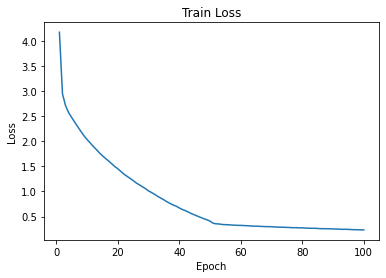

In [ ]:
# train/validation loss visualization
import matplotlib.pyplot as plt

plt.plot(np.arange(1, N_EPOCHS+1), train_loss_list)
#plt.plot(np.arange(1, N_EPOCHS, valid_every), valid_loss_list)
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

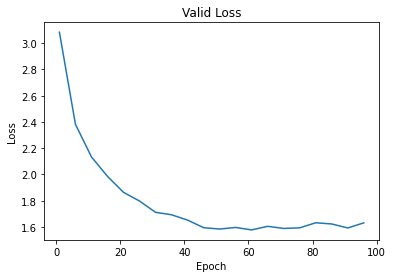

In [ ]:
plt.plot(np.arange(1, N_EPOCHS+1, valid_every), valid_loss_list)
plt.title('Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Test your model

loaded_model = LSTMSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)
loaded_model.load_state_dict(torch.load('lstm-attn-model.pt'))

test_loss = evaluate(loaded_model, test_dataloader, loss_fn)
print(f'\t Test. Loss: {test_loss:.3f} |  Test. PPL: {math.exp(test_loss):7.3f}')

	 Test. Loss: 1.547 |  Test. PPL:   4.697


## [Bonus] Implement GRU Seq2Seq Model

In [ ]:
class GRUEncoder(nn.Module):
    
    def __init__(self, in_dim, emb_dim, hid_dim, dropout):
        super(GRUEncoder, self).__init__()
        self.embedding = nn.Embedding(in_dim, emb_dim)
        self.gru = nn.GRU(input_size=emb_dim, hidden_size=hid_dim, num_layers=1, batch_first=True)
        self.dropout_layer = nn.Dropout(p=dropout)

    def forward(self, input, hidden):
        input_embed = self.dropout_layer(self.embedding(input)) # (B, max_len, emb_dim)
        
        enc_hiddens, hidden = self.gru(input_embed, hidden) # enc_hiddens -> (B, max_len, hid_dim)
        
        return enc_hiddens

In [ ]:
class AttnGRUDecoder(nn.Module):

    def __init__(self, emb_dim, hid_dim, out_dim, dropout, enc_hiddens=None):
        super(AttnGRUDecoder, self).__init__()
        self.t = 0 # (t)th token decoder
        self.enc_hiddens = enc_hiddens # encoder output (B, L, hid_dim)
        self.dropout = dropout
        
        self.embedding = nn.Embedding(out_dim, emb_dim)
        self.gru = nn.GRU(emb_dim + hid_dim, hid_dim, batch_first=True)
        self.classifier = nn.Linear(hid_dim, out_dim)
        self.dropout_layer = nn.Dropout(p=self.dropout)
  
    def forward(self, input, hidden):
        # s_i = f(s_(i-1), y_(i-1), c_i)
        query = hidden.squeeze(0) # set query to calculate attention
        query = torch.unsqueeze(query, dim=2) # query (B, hid_dim, 1) -> s_(i-1), self.enc_hiddens (B, L, hid_dim)
        attn_score = torch.matmul(self.enc_hiddens, query)  # (B, L, 1)
        attn_coef = F.softmax(attn_score, dim=1)
        attn_val = (attn_coef * self.enc_hiddens).sum(dim=1, keepdim=True)  # (B, 1, hid_dim) -> c_i
        attn_val = self.dropout_layer(attn_val)

        input_embed = self.dropout_layer(self.embedding(input))   # (B, 1, emb_dim) -> y_(i-1)
        input_cat = torch.concat([input_embed, attn_val], dim=-1)  # (B, 1, emb_dim + hid_dim) -> lstm input
        
        hiddens, hidden = self.gru(input_cat, hidden)  # hiddens -> (B, 1, hid_dim)
        hidden_dropout = self.dropout_layer(hidden.squeeze(0))
        oh_token_pred = F.log_softmax(self.classifier(hidden_dropout), dim=1) # (B, out_dim)
        pred_token_idx = oh_token_pred.max(1)[1].unsqueeze(1) # (B, 1)

        self.t += 1 # update time for each forward

        return oh_token_pred, pred_token_idx, hidden

In [ ]:
class GRUSeq2Seq(nn.Module):
    def __init__(self, in_dim, out_dim, emb_dim, hid_dim, device, dropout):
        super(GRUSeq2Seq, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.device = device
        self.dropout = dropout
        
        self.encoder = GRUEncoder(in_dim, emb_dim, hid_dim, dropout)
        self.decoder = AttnGRUDecoder(emb_dim, hid_dim, out_dim, dropout)
        
    def forward(self, src, trg):
        
        batch_size, mx_len = src.shape
        
        # Encoder (start from zero-hidden & zero-cell states)
        init_hidden = torch.zeros(1, batch_size, self.hid_dim).to(self.device)
        enc_hiddens = self.encoder(src, init_hidden) # (B, L, hid_dim)
        
        # Decoder
        self.decoder.enc_hiddens = enc_hiddens # set encoder's hidden states
        outputs = torch.zeros(mx_len, batch_size, dataset.output_lang.n_words).to(self.device) # to store each decoder's output
        
        # Decoder hidden/cell initialization
        hidden = enc_hiddens[:, -1, :].unsqueeze(0)   # (1, B, hid_dim)

        # First output token [SOS]
        # trg -> (B, mx_len) => [SOS] : (B, 1) -> (B, 1, emb_dim)
        input = trg[:, 0].unsqueeze(1) # (B, 1)
        
        for t in range(1, mx_len): # for each t'th token, get decoder outputs
            oh_token_pred, input, hidden = self.decoder(input, hidden)
            outputs[t-1] = oh_token_pred  # oh_token_pred -> (B, num_output_words)

        self.decoder.t=0 # after for loop, reset decoder's time to evaluate properly

        outputs = torch.permute(outputs, (1, 2, 0))
        # outputs -> (L, B, num_output_words) => (B, num_output_words, L)
        return outputs

In [ ]:
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words
hid_dim = 1024 #256
emb_dim = 1024 #256
dropout = 0.5
learning_rate=1e-3
N_EPOCHS = 30
valid_every=5
best_valid_loss = float('inf')

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR as MultiStepLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gru_model = GRUSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)

optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)
scheduler = MultiStepLR(optimizer, milestones=[10], gamma=0.1)
loss_fn = nn.NLLLoss(ignore_index = dataset.output_lang_pad)

train_loss_list = []    # for every epoch
valid_loss_list = []    # for every 5 epochs

for epoch in range(N_EPOCHS):
    
    train_loss = train(gru_model, train_dataloader, optimizer, loss_fn, 1)
    train_loss_list.append(train_loss)
    scheduler.step()
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.7f} | Train PPL: {math.exp(train_loss):7.3f}')
    
    if epoch%valid_every==0:
        print("==========================")
        valid_loss = evaluate(gru_model, valid_dataloader, loss_fn)
        valid_loss_list.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            gru_model.decoder.t=0
            torch.save(gru_model.state_dict(), 'gru-attn-model.pt')

        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01
	Train Loss: 3.1146916 | Train PPL:  22.526
	 Val. Loss: 2.481 |  Val. PPL:  11.953
Epoch: 02
	Train Loss: 2.3979342 | Train PPL:  11.000
Epoch: 03
	Train Loss: 2.0964141 | Train PPL:   8.137
Epoch: 04
	Train Loss: 1.8360295 | Train PPL:   6.272
Epoch: 05
	Train Loss: 1.6181364 | Train PPL:   5.044
Epoch: 06
	Train Loss: 1.4392182 | Train PPL:   4.217
	 Val. Loss: 1.710 |  Val. PPL:   5.531
Epoch: 07
	Train Loss: 1.2818150 | Train PPL:   3.603
Epoch: 08
	Train Loss: 1.1370130 | Train PPL:   3.117
Epoch: 09
	Train Loss: 1.0286618 | Train PPL:   2.797
Epoch: 10
	Train Loss: 0.9272217 | Train PPL:   2.527
Epoch: 11
	Train Loss: 0.7624662 | Train PPL:   2.144
	 Val. Loss: 1.610 |  Val. PPL:   5.003
Epoch: 12
	Train Loss: 0.7076680 | Train PPL:   2.029
Epoch: 13
	Train Loss: 0.6733205 | Train PPL:   1.961
Epoch: 14
	Train Loss: 0.6512425 | Train PPL:   1.918
Epoch: 15
	Train Loss: 0.6242630 | Train PPL:   1.867
Epoch: 16
	Train Loss: 0.6032311 | Train PPL:   1.828
	 Val. Loss: 1.6

In [ ]:
loaded_model = GRUSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)
loaded_model.load_state_dict(torch.load('gru-attn-model.pt'))

test_loss = evaluate(loaded_model, test_dataloader, loss_fn)
print(f'\t Test. Loss: {test_loss:.3f} |  Test. PPL: {math.exp(test_loss):7.3f}')

	 Test. Loss: 1.546 |  Test. PPL:   4.693


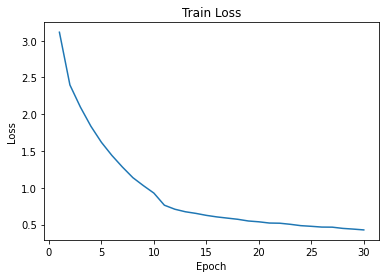

In [ ]:
# train/validation loss visualization
import matplotlib.pyplot as plt

plt.plot(np.arange(1, N_EPOCHS+1), train_loss_list)
#plt.plot(np.arange(1, N_EPOCHS, valid_every), valid_loss_list)
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

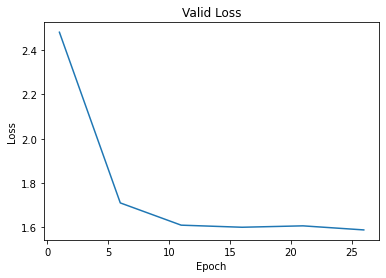

In [ ]:
plt.plot(np.arange(1, N_EPOCHS+1, valid_every), valid_loss_list)
plt.title('Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 2. Seq2Seq model with Transformer

## Implement Transformer Seq2Seq Model

In [ ]:
class TransEncoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, ff_dim, dropout, device, max_length = MAX_LENGTH):
        super().__init__()

        self.hid_dim = hid_dim
        self.max_length = max_length

        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        
        encoder_layer = TransformerEncoderLayer(hid_dim, n_heads, ff_dim, dropout, batch_first=True)
        self.encoder = TransformerEncoder(encoder_layer, n_layers)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor([hid_dim], device = device, dtype=torch.float32))
        
    def forward(self, src, pos_emb, src_mask):
        '''
        INPUT
        - src: source language batched data (B, max_len)
        - pos_emb: positional embedding (max_len, hid_dim)
        - src_mask: padding mask tensor for source sentences (B, max_len)

        OUTPUT
        What to be returned depends on your implementation of TransSeq2Seq.
        Feel free to return outputs you need.
        Some examples below,

        - encoder output (B, max_len, hid_dim)
        '''
        batch_size, src_len = src.shape
        
        src_embed = self.tok_embedding(src) * self.scale  # (B, max_len, hid_dim)
        # print(src_embed)
        src_input = self.dropout(src_embed + pos_emb)     # (B, max_len, hid_dim)
        
        enc_output = self.encoder(src_input, src_key_padding_mask=src_mask)

        return enc_output

In [ ]:
class TransDecoder(nn.Module):
    def __init__(self, out_dim, hid_dim, n_layers, n_heads, ff_dim, dropout, device, max_length = MAX_LENGTH):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.max_length = max_length
        
        self.tok_embedding = nn.Embedding(out_dim, hid_dim)
        
        decoder_layer = TransformerDecoderLayer(hid_dim, n_heads, ff_dim, dropout, batch_first=True)
        self.decoder = TransformerDecoder(decoder_layer, n_layers)
        
        self.fc_out = nn.Linear(hid_dim, out_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.tensor([hid_dim], device = device, dtype=torch.float32))
        
    def forward(self, trg, pos_emb, enc_src, trg_mask, trg_sub_mask, src_mask):
        '''
        INPUT
        - trg: target language batched data (B, max_len)
        - pos_emb: positional embedding (max_len, hid_dim)
        - enc_src: encoder outputs (B, max_len, hid_dim)
        - trg_mask: padding mask tensor for target sentences (B, max_len)
        - trg_sub_mask: subsequent mask for target sentences (max_len, max_len)
        - src_mask: padding mask tensor for source sentences (B, max_len)

        OUTPUT
        What to be returned depends on your implementation of TransSeq2Seq.
        Feel free to return outputs you need.
        Some examples below,

        - decoder output (B, max_len, out_dim)
        '''
        batch_size, trg_len = trg.shape

        trg_embed = self.tok_embedding(trg) * self.scale   # (B, max_len, hid_dim)
        trg_input = self.dropout(trg_embed + pos_emb)     # (B, max_len, hid_dim)
        # print(enc_src)
        dec_output = self.decoder(tgt=trg_input, memory=enc_src,
                                  tgt_mask=trg_sub_mask,
                                  tgt_key_padding_mask=trg_mask,
                                  memory_key_padding_mask=src_mask)
        # dec_output = self.dropout(dec_output)
        dec_output = self.fc_out(dec_output)
        
        return dec_output       # (B, max_len, out_dim)

In [ ]:
class TransSeq2Seq(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, ff_dim, n_layers, n_heads, dropout_p, device, max_length=MAX_LENGTH):
        super().__init__()
        
        self.device = device
        self.hid_dim = hid_dim
        self.max_length = max_length

        self.encoder = TransEncoder(in_dim, hid_dim, n_layers[0], n_heads, ff_dim, dropout_p, device)
        self.decoder = TransDecoder(out_dim, hid_dim, n_layers[1], n_heads, ff_dim, dropout_p, device)
        
    def make_src_mask(self, src):
        '''
        INPUT
        - src: batched input sentences (B, max_len)

        OUTPUT
        - Boolean padding mask tensor (B, max_len)
        '''
        # src_mask shape (B, max_len) is the argument 'src_key_padding_mask'
        # for torch.nn.TransformerEncoder.forward()
        # Position with True : Not allowed to attend
        # Position with False : will be unchanged
        src_padding_mask = (src == dataset.input_lang_pad).to(self.device)  # (B, max_len)
        return src_padding_mas

    def make_trg_mask(self, trg):
        '''
        INPUT
        - trg: batched target sentences (B, max_len)

        OUTPUT
        - A tuple of a padding mask tensor and a subsequent mask tensor ((B, max_len), (max_len, max_len))
        '''
        # Position with True : Not allowed to attend
        # Position with False : will be unchanged
        trg_padding_mask = (trg == dataset.output_lang_pad).to(self.device)   # (B, max_len)
        trg_sub_mask = torch.triu(torch.ones((self.max_length, self.max_length)), diagonal=1).bool().to(self.device)

        return trg_padding_mask, trg_sub_mask

    def forward(self, src, trg):
        '''
        INPUT
        - src: source language batched data (B, max_len)
        - trg: target language batched data (B, max_len)

        OUTPUT
        - decoder output (B, out_dim, max_len)
        
        '''
        src_mask = self.make_src_mask(src)
        trg_mask, trg_sub_mask = self.make_trg_mask(trg)
        pos_emb = self.get_pos_emb()
        enc_output = self.encoder(src=src, pos_emb=pos_emb, src_mask=src_mask)
        dec_output = self.decoder(trg=trg, pos_emb=pos_emb, enc_src=enc_output, 
                                  trg_mask=trg_mask, trg_sub_mask=trg_sub_mask, 
                                  src_mask=src_mask)
        dec_output = torch.permute(dec_output, (0, 2, 1))
  
        return dec_output
    
    
    def get_pos_emb(self):
        '''
        OUTPUT
        - positional embedding tensor (max_len, hid_dim)
        '''
        i = torch.arange(self.hid_dim).to(self.device)
        divisor = 1 / torch.pow(10000, 2 * (i // 2) / self.hid_dim)    # (hid_dim,)
        pos = torch.arange(self.max_length).view(-1, 1).to(self.device)     # (max_len, 1)
        angles = pos * divisor        # (max_len, hid_dim)
        pos_embedding = torch.zeros_like(angles).to(self.device)   # (max_len, hid_dim)
        pos_embedding[:, 0::2] = torch.sin(angles[:, 0::2]).to(self.device)
        pos_embedding[:, 1::2] = torch.cos(angles[:, 1::2]).to(self.device)

        return pos_embedding        # (max_len, hid_dim)

## Training

In [ ]:
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words
hid_dim = 256
ff_dim = 1024
n_enc_layers = 4
n_dec_layers = 4
n_layers = [n_enc_layers, n_dec_layers]
n_heads = 8
dropout = 0.3

learning_rate=1e-4
N_EPOCHS = 100
valid_every=5
best_valid_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransSeq2Seq(in_dim, out_dim, hid_dim, ff_dim, n_layers, n_heads, dropout, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(ignore_index = dataset.output_lang_pad)
# print(model)

torch.Size([10, 256])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


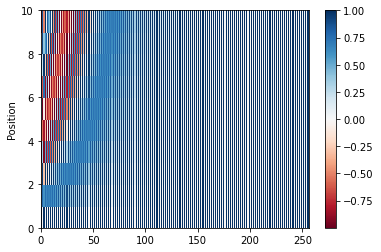

In [ ]:
pe = model.get_pos_emb()
pe = pe.to('cpu')
plt.pcolormesh(pe.squeeze(1), cmap='RdBu')
print(pe.shape)


plt.xlim((0, hid_dim))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
# Train your model
for epoch in range(N_EPOCHS):
    
    train_loss = train(model, train_dataloader, optimizer, loss_fn, 1)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    
    if epoch%valid_every==0:
        print("==========================")
        valid_loss = evaluate(model, valid_dataloader, loss_fn)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            model.decoder.t=0
            torch.save(model.state_dict(), 'transformer-model.pt')

        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Epoch: 01
	Train Loss: 3.999 | Train PPL:  54.538
	 Val. Loss: 2.037 |  Val. PPL:   7.667
Epoch: 02
	Train Loss: 1.957 | Train PPL:   7.079
Epoch: 03
	Train Loss: 1.509 | Train PPL:   4.520
Epoch: 04
	Train Loss: 1.263 | Train PPL:   3.534
Epoch: 05
	Train Loss: 1.099 | Train PPL:   3.002
Epoch: 06
	Train Loss: 0.968 | Train PPL:   2.633
	 Val. Loss: 0.753 |  Val. PPL:   2.124
Epoch: 07
	Train Loss: 0.857 | Train PPL:   2.355
Epoch: 08
	Train Loss: 0.763 | Train PPL:   2.145
Epoch: 09
	Train Loss: 0.684 | Train PPL:   1.982
Epoch: 10
	Train Loss: 0.619 | Train PPL:   1.858
Epoch: 11
	Train Loss: 0.559 | Train PPL:   1.748
	 Val. Loss: 0.460 |  Val. PPL:   1.583
Epoch: 12
	Train Loss: 0.508 | Train PPL:   1.662
Epoch: 13
	Train Loss: 0.463 | Train PPL:   1.589
Epoch: 14
	Train Loss: 0.422 | Train PPL:   1.525
Epoch: 15
	Train Loss: 0.386 | Train PPL:   1.471
Epoch: 16
	Train Loss: 0.355 | Train PPL:   1.426
	 Val. Loss: 0.320 |  Val. PPL:   1.377
Epoch: 17
	Train Loss: 0.325 | Train PPL

In [ ]:
# Test your model
loaded_model = TransSeq2Seq(in_dim, out_dim, hid_dim, ff_dim, n_layers, n_heads, dropout, device).to(device)
loaded_model.load_state_dict(torch.load('transformer-model.pt'))

test_loss = evaluate(loaded_model, test_dataloader, loss_fn)
print(f'\t Test. Loss: {valid_loss:.3f} |  Test. PPL: {math.exp(valid_loss):7.3f}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


	 Test. Loss: 0.187 |  Test. PPL:   1.206
